In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from pymc import sampling_jax
import altair as alt
alt.renderers.enable('mimetype')
pm.__version__

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


'5.0.2'

# Dyad sharing model

In [3]:
kl_households = pd.read_csv("../../../datasets/kl_households.csv")
kl_dyads = pd.read_csv("../../../datasets/kl_dyads.csv")

In [11]:
kl_dyads.head()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0


In [17]:
giver_idx, givers = pd.factorize(kl_dyads['hidA'], sort=True)
receiver_idx, receivers = pd.factorize(kl_dyads['hidB'], sort=True)
giver_gifts = kl_dyads['giftsAB'].values
receiver_gifts = kl_dyads['giftsBA'].values
ties = kl_dyads.index.values

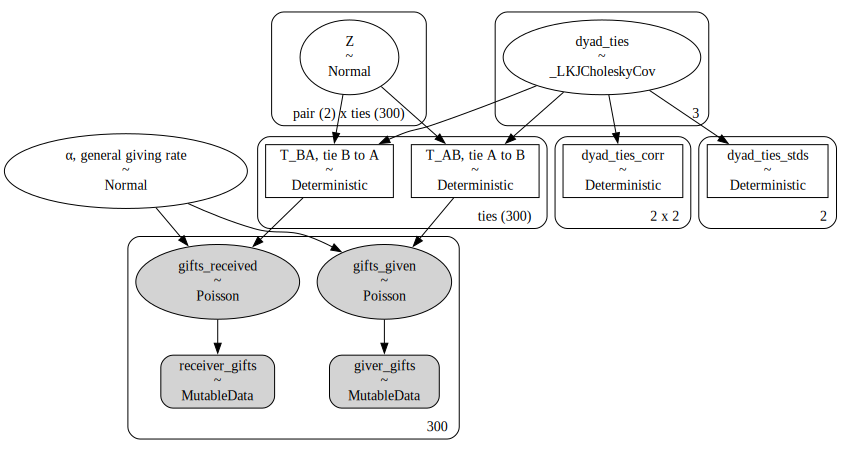

In [31]:
coords = {
    'givers': givers,
    'receivers': receivers,
    "pair": ['giver', 'receiver'],
    'ties': ties
}

with pm.Model(coords=coords) as base_model:
    #setup data    
    g_counts = pm.MutableData("giver_gifts", giver_gifts)
    r_counts = pm.MutableData("receiver_gifts", receiver_gifts)

    #basic giving rate
    α = pm.Normal("α, general giving rate", 0, 1)

    #dyad effects (unobservable)
    # this is not identical to lecture - can't force a single variance to be used without getting deeper in internals
    σ = pm.Exponential.dist(1.0)    
    Z = pm.Normal('Z', mu=0, sigma=1, dims=["pair", "ties"])
    chol, corr, stds = pm.LKJCholeskyCov('dyad_ties', n=len(coords['pair']), eta=2, sd_dist=σ, compute_corr=True)
    vals = pm.math.dot(chol, Z)
    T_AB = pm.Deterministic("T_AB, tie A to B", vals[0, :], dims="ties")
    T_BA = pm.Deterministic("T_BA, tie B to A", vals[1, :], dims="ties")

    #set up expected rates        
    λ_AB = pm.math.exp(α + T_AB[ties])
    λ_BA = pm.math.exp(α + T_BA[ties])

    #set up likelihoods
    pm.Poisson("gifts_given", mu=λ_AB, observed = g_counts)
    pm.Poisson("gifts_received", mu=λ_BA, observed = r_counts)

pm.model_to_graphviz(base_model)

In [32]:
with base_model:
    base_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:02.054849
Sampling...
Sampling time =  0:00:05.846094
Transforming variables...
Transformation time =  0:00:02.494808


In [33]:
az.summary(
    base_trace, 
    var_names=['dyad_ties_corr', 'dyad_ties_stds', 'α, general giving rate'],
    coords={"dyad_ties_corr_dim_0": [1], "dyad_ties_corr_dim_1": [0]})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"dyad_ties_corr[1, 0]",0.351,0.069,0.221,0.478,0.003,0.002,492.0,1085.0,1.01
dyad_ties_stds[0],1.394,0.089,1.228,1.553,0.004,0.003,514.0,1128.0,1.01
dyad_ties_stds[1],1.492,0.085,1.327,1.647,0.004,0.003,442.0,902.0,1.01
"α, general giving rate",0.545,0.082,0.388,0.693,0.003,0.002,728.0,1535.0,1.01


In [ ]:
g_id = pm.MutableData("giver_ids", giver_idx, coords="givers")
r_id = pm.MutableData("receiver_ids", giver_idx, coords="receivers")